In [1]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *
from Helper_functions import *

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

X, y, feature_names, categorical_features, continuous_features, actionable_features = get_and_prepare_german_dataset()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_pos = X[y == 1]
X_neg = X[y == 0]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

C:\Users\hamma\miniconda3\envs\cem_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
from Model import NeuralNetwork

model0 = NeuralNetwork(X.shape[1], 200, 2)
model1= NeuralNetwork(X.shape[1], 200, 2)
model2= NeuralNetwork(X.shape[1], 200, 2)
model3= NeuralNetwork(X.shape[1], 200, 2)
model4= NeuralNetwork(X.shape[1], 200, 2)
model5= NeuralNetwork(X.shape[1], 200, 2)
model6= NeuralNetwork(X.shape[1], 200, 2)

In [3]:
models = [model0,model1, model2, model3, model4, model5, model6]
lambdas = [0,0.05,0.1,0.15,0.2,0.25,0.3]

model_path = f"models/germanCredit_model_0.pth"
model0.load_state_dict(torch.load(model_path))
model0.eval()  # Set to evaluation mode

# Load saved weights
for lambda_model, lamda in zip(models[1:], lambdas[1:]):
    model_path = f"models/germanCredit_model_lambda_{lamda:.2f}.pth"
    lambda_model.load_state_dict(torch.load(model_path))
    lambda_model.eval()  # Set to evaluation mode


In [4]:
import torch.nn.functional as F
class WrappedModelForAlibi:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def predict(self, x):
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32)
            logits = self.model(x_tensor)

            if logits.ndim == 1:
                logits = logits.unsqueeze(0)

            probs = F.softmax(logits, dim=1)
            return probs.numpy()


## Evalutation using CEM:

In [6]:
import tensorflow as tf
from alibi.explainers import CEM
tf.compat.v1.disable_eager_execution()
from tqdm import tqdm


cost_of_recourses_l1 = []
cost_of_recourses_l2 = []

for (model, lamda ) in zip(models,lambdas):
    print(f"Evaluating using CEM with lambda = {lamda}")

    X_false_negatives, X_true_negatives, _, _ = split_by_classification(model, X_neg)

    X_np = X.numpy()

    predict_fn = WrappedModelForAlibi(model).predict
    # Feature ranges from training data
    feature_min = X_np.min(axis=0)
    feature_max = X_np.max(axis=0)
    feature_range = (feature_min, feature_max)

    cem = CEM(
        predict_fn,
        mode='PN',
        shape=(1, X_np.shape[1]),
        max_iterations=100,
        feature_range = feature_range
    )
    # Fit on a sample of training data (preferably more than 1)
    cem.fit(X_np)


    l1_distances = []
    l2_distances = []

    # Loop over each instance
    for i in tqdm(range(len(X_true_negatives)), desc="Generating CEM counterfactuals"):
        x = X_true_negatives[i:i+1]  # keep shape (1, n_features)
        explanation = cem.explain(x)

        # Extract original and PN (pertinent negative) instance
        original = explanation.data['X'][0]
        pn = explanation.data['PN']

        if pn is not None:
            cf = pn[0]
            l1_distance = torch.norm(original - cf, p=1).item()
            l2_distance = torch.norm(original - cf, p=2).item()
            l1_distances.append(l1_distance)
            l2_distances.append(l2_distance)

    l1_distances = np.array(l1_distances)
    l2_distances = np.array(l2_distances)

    # Compute mean L1 distance
    cost_of_recourses_l1.append(l1_distances)
    cost_of_recourses_l2.append(l1_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {np.mean(l1_distances):.2f}")
    print(f"Mean L2 distance for negatively classified data using DiCE: {np.mean(l2_distances):.2f}")

C:\Users\hamma\miniconda3\envs\cem_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluating using CEM with lambda = 0



Generating CEM counterfactuals:   0%|          | 0/122 [00:00<?, ?it/s]C:\Users\hamma\AppData\Local\Temp\ipykernel_15220\4173109287.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32)
Generating CEM counterfactuals: 100%|██████████| 122/122 [07:53<00:00,  3.88s/it]


Mean L1 distance for negatively classified data using DiCE: 2.06
Mean L2 distance for negatively classified data using DiCE: 1.01
Evaluating using CEM with lambda = 0.05


Generating CEM counterfactuals: 100%|██████████| 155/155 [11:26<00:00,  4.43s/it]


Mean L1 distance for negatively classified data using DiCE: 2.26
Mean L2 distance for negatively classified data using DiCE: 1.08
Evaluating using CEM with lambda = 0.1


Generating CEM counterfactuals: 100%|██████████| 183/183 [17:20<00:00,  5.68s/it]


Mean L1 distance for negatively classified data using DiCE: 3.53
Mean L2 distance for negatively classified data using DiCE: 1.72
Evaluating using CEM with lambda = 0.15


Generating CEM counterfactuals: 100%|██████████| 210/210 [15:09<00:00,  4.33s/it]


Mean L1 distance for negatively classified data using DiCE: 4.16
Mean L2 distance for negatively classified data using DiCE: 1.90
Evaluating using CEM with lambda = 0.2


Generating CEM counterfactuals: 100%|██████████| 228/228 [19:29<00:00,  5.13s/it]


Mean L1 distance for negatively classified data using DiCE: 6.11
Mean L2 distance for negatively classified data using DiCE: 2.85
Evaluating using CEM with lambda = 0.25


Generating CEM counterfactuals: 100%|██████████| 248/248 [21:19<00:00,  5.16s/it]


Mean L1 distance for negatively classified data using DiCE: 4.17
Mean L2 distance for negatively classified data using DiCE: 1.72
Evaluating using CEM with lambda = 0.3


Generating CEM counterfactuals: 100%|██████████| 258/258 [21:39<00:00,  5.04s/it]

Mean L1 distance for negatively classified data using DiCE: 4.67
Mean L2 distance for negatively classified data using DiCE: 1.93


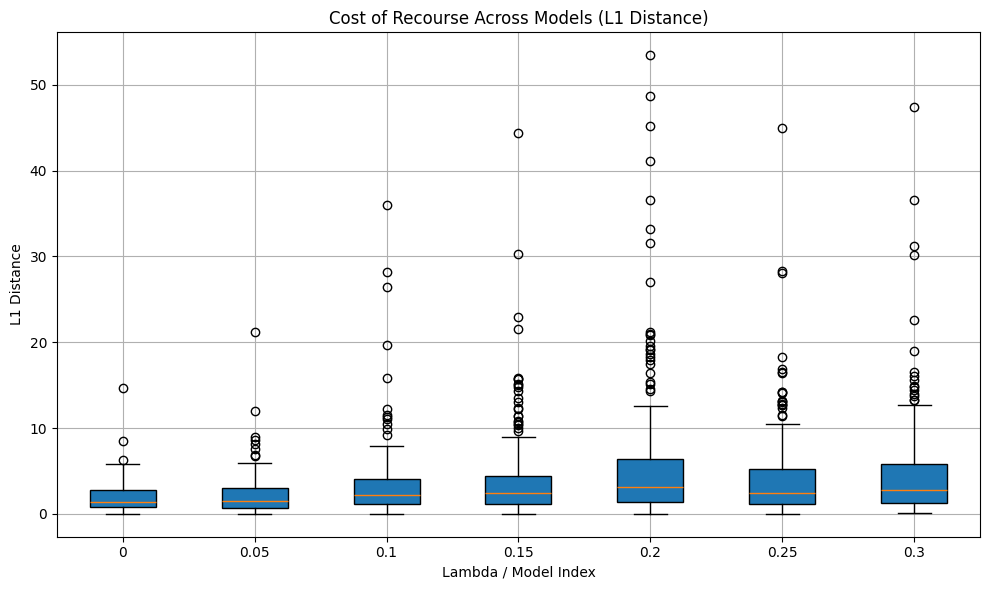

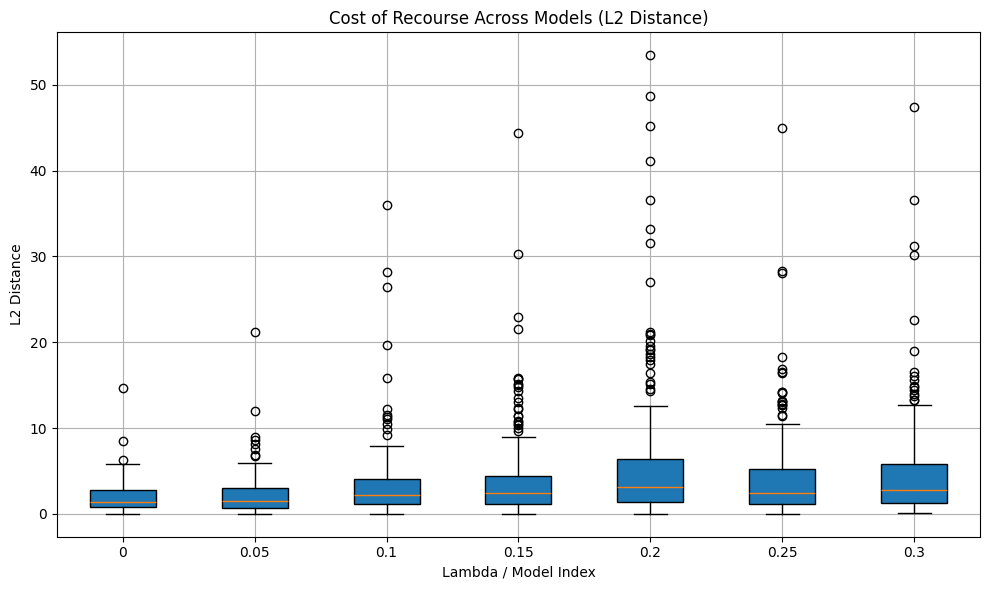

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l1,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L1 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L1 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l2,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L2 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L2 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

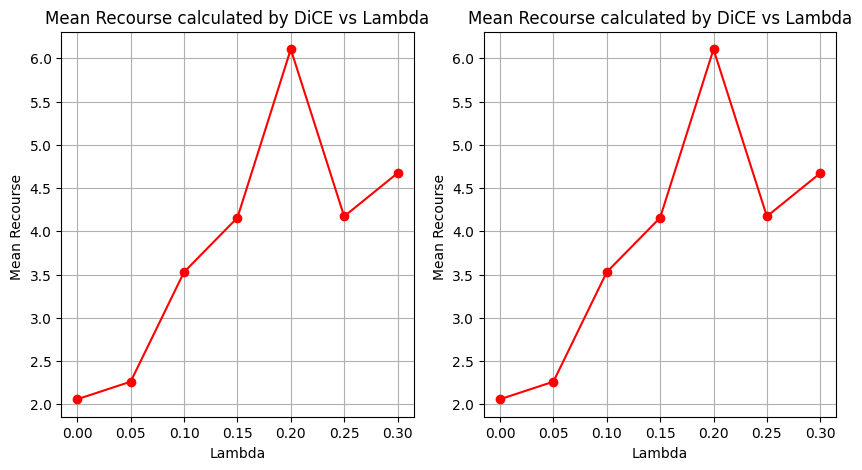

In [8]:
l1_means = [np.mean(sublist) for sublist in cost_of_recourses_l1]
l2_means = [np.mean(sublist) for sublist in cost_of_recourses_l2]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(lambdas, l1_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lambdas, l2_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

## now we caluclate the counterfactuals only for instances that are classified as negative by all the models

In [5]:
commun_negatives = X_neg

for model in models:
    _, commun_negatives, _, _ = split_by_classification(model, commun_negatives)

In [6]:
import tensorflow as tf
from alibi.explainers import CEM
tf.compat.v1.disable_eager_execution()
from tqdm import tqdm


cost_of_recourses_l1 = []
cost_of_recourses_l2 = []

for (model, lamda ) in zip(models,lambdas):
    print(f"Evaluating using CEM with lambda = {lamda}")

    X_np = X.numpy()

    predict_fn = WrappedModelForAlibi(model).predict
    # Feature ranges from training data
    feature_min = X_np.min(axis=0)
    feature_max = X_np.max(axis=0)
    feature_range = (feature_min, feature_max)

    cem = CEM(
        predict_fn,
        mode='PN',
        shape=(1, X_np.shape[1]),
        max_iterations=100,
        feature_range = feature_range
    )
    # Fit on a sample of training data (preferably more than 1)
    cem.fit(X_np)


    l1_distances = []
    l2_distances = []

    # Loop over each instance
    for i in tqdm(range(len(commun_negatives)), desc="Generating CEM counterfactuals"):
        x = commun_negatives[i:i+1]  # keep shape (1, n_features)
        explanation = cem.explain(x)

        # Extract original and PN (pertinent negative) instance
        original = explanation.data['X'][0]
        pn = explanation.data['PN']

        if pn is not None:
            cf = pn[0]
            l1_distance = torch.norm(original - cf, p=1).item()
            l2_distance = torch.norm(original - cf, p=2).item()
            l1_distances.append(l1_distance)
            l2_distances.append(l2_distance)

    l1_distances = np.array(l1_distances)
    l2_distances = np.array(l2_distances)

    # Compute mean L1 distance
    cost_of_recourses_l1.append(l1_distances)
    cost_of_recourses_l2.append(l1_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {np.mean(l1_distances):.2f}")
    print(f"Mean L2 distance for negatively classified data using DiCE: {np.mean(l2_distances):.2f}")

C:\Users\hamma\miniconda3\envs\cem_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluating using CEM with lambda = 0



Generating CEM counterfactuals:   0%|          | 0/122 [00:00<?, ?it/s]C:\Users\hamma\AppData\Local\Temp\ipykernel_35116\4173109287.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32)
Generating CEM counterfactuals: 100%|██████████| 122/122 [11:57<00:00,  5.88s/it]


Mean L1 distance for negatively classified data using DiCE: 2.06
Mean L2 distance for negatively classified data using DiCE: 1.01
Evaluating using CEM with lambda = 0.05


Generating CEM counterfactuals: 100%|██████████| 122/122 [11:45<00:00,  5.78s/it]


Mean L1 distance for negatively classified data using DiCE: 2.83
Mean L2 distance for negatively classified data using DiCE: 1.34
Evaluating using CEM with lambda = 0.1


Generating CEM counterfactuals: 100%|██████████| 122/122 [10:41<00:00,  5.26s/it]


Mean L1 distance for negatively classified data using DiCE: 4.82
Mean L2 distance for negatively classified data using DiCE: 2.31
Evaluating using CEM with lambda = 0.15


Generating CEM counterfactuals: 100%|██████████| 122/122 [10:21<00:00,  5.10s/it]


Mean L1 distance for negatively classified data using DiCE: 6.49
Mean L2 distance for negatively classified data using DiCE: 2.90
Evaluating using CEM with lambda = 0.2


Generating CEM counterfactuals: 100%|██████████| 122/122 [10:21<00:00,  5.10s/it]


Mean L1 distance for negatively classified data using DiCE: 10.45
Mean L2 distance for negatively classified data using DiCE: 4.83
Evaluating using CEM with lambda = 0.25


Generating CEM counterfactuals: 100%|██████████| 122/122 [10:10<00:00,  5.01s/it]


Mean L1 distance for negatively classified data using DiCE: 7.67
Mean L2 distance for negatively classified data using DiCE: 3.00
Evaluating using CEM with lambda = 0.3


Generating CEM counterfactuals: 100%|██████████| 122/122 [10:13<00:00,  5.02s/it]

Mean L1 distance for negatively classified data using DiCE: 8.71
Mean L2 distance for negatively classified data using DiCE: 3.27


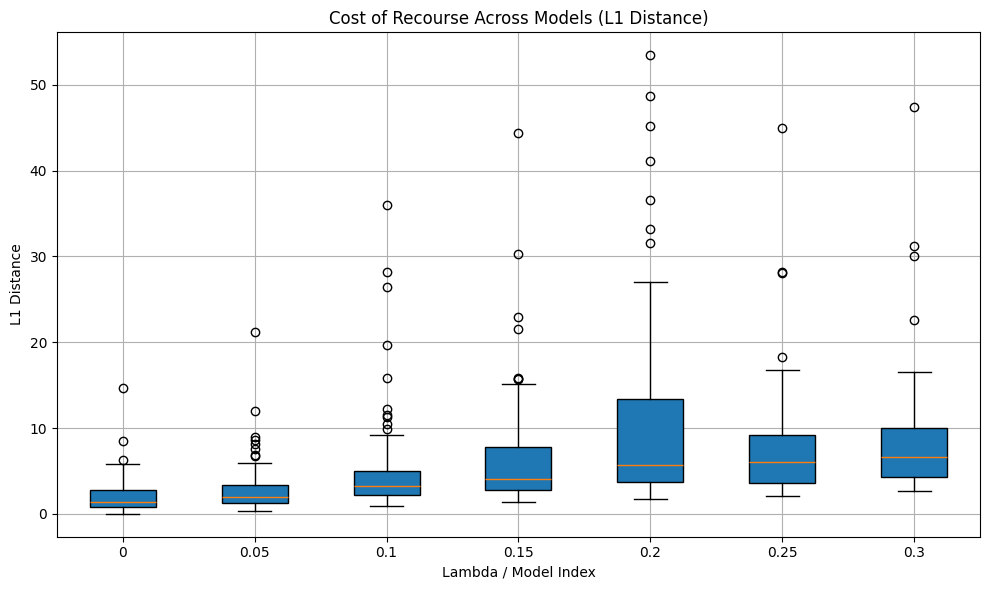

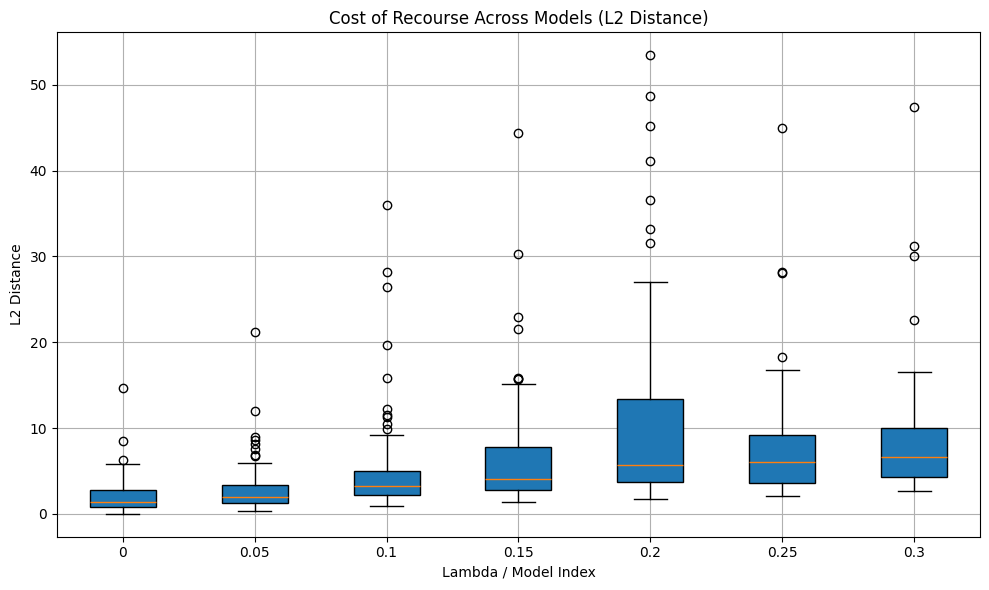

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l1,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L1 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L1 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l2,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L2 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L2 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

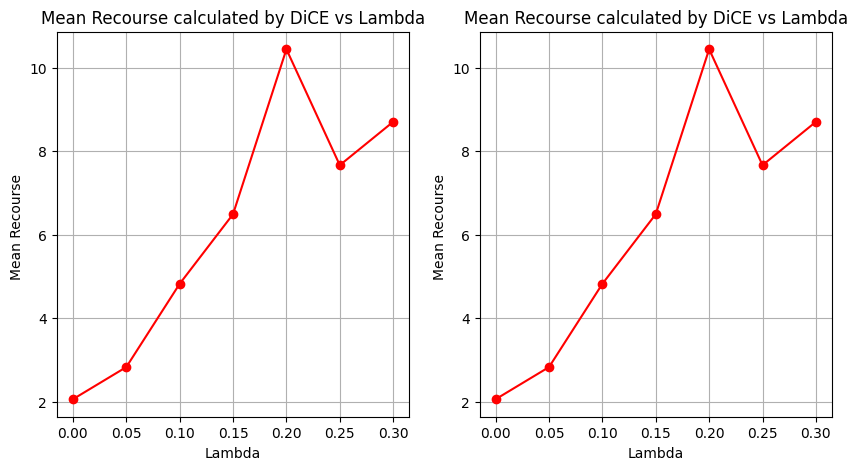

In [8]:
l1_means = [np.mean(sublist) for sublist in cost_of_recourses_l1]
l2_means = [np.mean(sublist) for sublist in cost_of_recourses_l2]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(lambdas, l1_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lambdas, l2_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)